# RNA velocity with scVelo and TopOMetry

In this tutorial, we'll use TopOMetry results' with [scVelo](https://scvelo.readthedocs.io/) to obtain better estimates and visualizations of [RNA velocity](https://www.nature.com/articles/s41586-018-0414-6). RNA velocity allows identifying the directionality of cellular trajectories in single-cell datasets, and is in itself also intrinsically related to the concept of ['phenotypic manifold / epigenetic landscape'](https://doi.org/10.1002/bies.201100031) on which TopOMetry is theoretically grounded.

Generally speaking, RNA velocity vectors are the difference between two vectors: the actual spliced/unspliced projection vector (i.e. the 'velocity-based expectation') and a directed k-nearest-neighbors vector (i.e., the 'background expectation'), which is based on a latent embedding (e.g., PCA, t-SNE or UMAP). TopOMetry can be useful when estimating RNA velocity by providing embeddings that preserve most of the local geometry of the epigenetic manifold, resulting in more accurate backgroud expectations and thus more reliable RNA velocity vectors.

NOTE: This vector sum is discussed in Section 11 of the Supplementary Note 2 of the brilliant RNA velocity [manuscript](https://www.nature.com/articles/s41586-018-0414-6) by Gioele La Manno. His [PhD thesis](http://hdl.handle.net/10616/46460) is also a great reading material for those who want to know more about the topic of estimating phenotypic manifolds from single-cell data.

To start, let's import some libraries:

In [1]:
import numpy as np
import scanpy as sc
import scvelo as scv
import topo as tp
import matplotlib

In [2]:
scv.set_figure_params('scvelo', dpi=100, fontsize=14, dpi_save=600, format='tif')

For this tutorial, we'll use the scRNAseq dataset from Gioele La Manno's [paper](https://www.nature.com/articles/s41586-018-0414-6), comprised of ~18,000 cells from the murine dentate gyrus. It is a well-known system and readily available within scVelo, so this is quite convenient.

In [3]:
adata = scv.datasets.dentategyrus_lamanno()
adata

AnnData object with n_obs × n_vars = 18213 × 27998
    obs: 'Age', 'clusters'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'clusters_colors'
    obsm: 'X_tsne'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

## Standard workflow

Before doing any velocity-related processing (which takes into account spliced and unpliced gene counts), let's preprocess the full matrix using the default scanpy workflow. 

Here, we'll use the `tp.sc.preprocess()` function, which conveniently performs the following preprocessing steps using scanpy:

```

# Normalization and log-transformation for variance stabilization
sc.pp.normalize_total(AnnData, target_sum=target_sum)
sc.pp.log1p(AnnData)

# Selection of highly-variable genes
sc.pp.highly_variable_genes(AnnData)
AnnData = AnnData[:, AnnData.var.highly_variable]

# Z-score transformation
sc.pp.scale(AnnData, max_value=max_value)

```

In [4]:
# Get the full matrix:
adata.X = adata.layers['matrix']

# Default preprocessing
adata = tp.sc.preprocess(adata)
adata.layers['scaled_matrix'] = adata.X.copy()

Next, we proceed with the standard Scanpy workflow, based on PCA-derived neighborhood graphs:

In [5]:
adata.X

array([[ 1.2147145 , -0.6222353 , -0.13174099, ..., -0.20140855,
        -0.46448907,  0.33476245],
       [ 0.05458286, -0.6222353 , -0.13174099, ..., -0.20140855,
        -0.46448907,  0.9176912 ],
       [ 1.3682595 , -0.6222353 , -0.13174099, ..., -0.20140855,
        -0.46448907, -0.87588924],
       ...,
       [-0.9266163 , -0.6222353 , -0.13174099, ..., -0.20140855,
         2.5688424 ,  0.5813992 ],
       [ 1.9697523 , -0.6222353 , -0.13174099, ..., -0.20140855,
        -0.46448907, -0.87588924],
       [-0.9266163 , -0.6222353 , -0.13174099, ..., -0.20140855,
        -0.46448907, -0.87588924]], dtype=float32)

In [6]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

2023-06-14 18:55:15.169046: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-14 18:55:15.971944: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


And visualize the resulting UMAP, colored by the cell-type labels provided in the original manuscript:

/home/davi/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


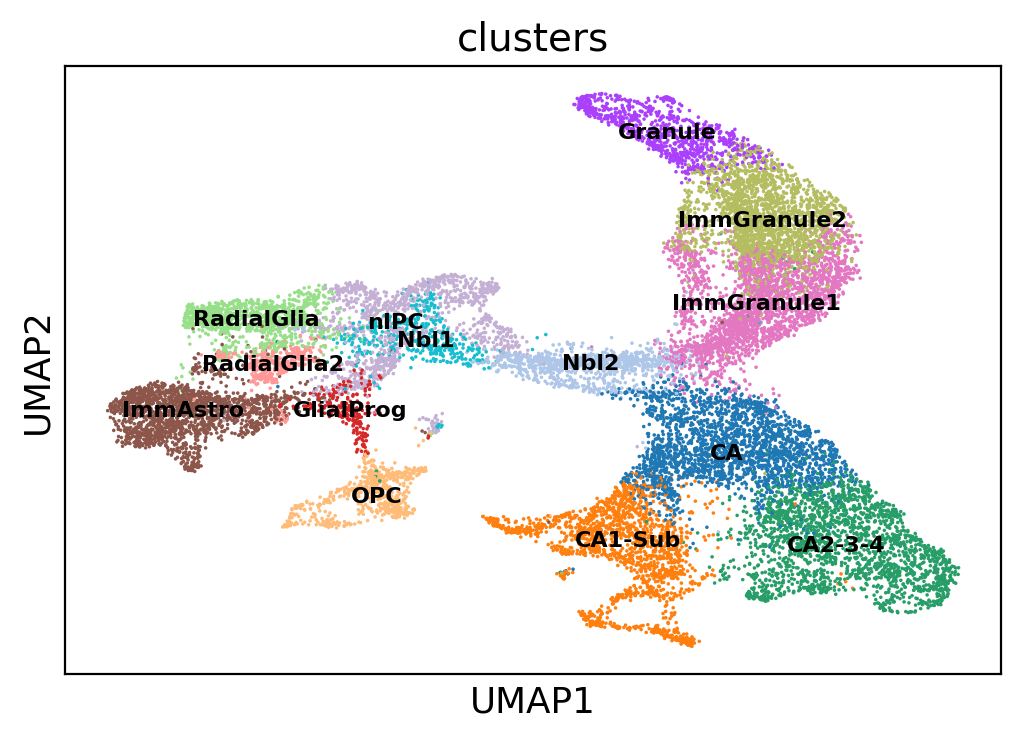

In [7]:
sc.pl.umap(adata, color='clusters', legend_loc='on data', legend_fontsize=8)

After we're done with the full matrix, we can proceed with the preprocessing of the spliced and unspliced fractions. scVelo uses the function `scv.pp.filter_and_normalize` for this. After that, it computes PCA and directed k-nearest-neighbors graphs with the `scv.pp.moments` function.

In [8]:
# Default scvelo preprocessing
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_neighbors=10)

Filtered out 1686 genes that are detected 20 counts (shared).
Normalized count data: spliced, unspliced.
Extracted 2000 highly variable genes.
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


After this, we're ready to estimate RNA velocity properly:

In [9]:
scv.tl.velocity(adata, vkey='standard_velocity')
scv.tl.velocity_graph(adata, vkey='standard_velocity')

computing velocities
    finished (0:00:03) --> added 
    'standard_velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/12 cores)


  0%|          | 0/18213 [00:00<?, ?cells/s]

    finished (0:00:25) --> added 
    'standard_velocity_graph', sparse matrix with cosine correlations (adata.uns)


And then we can visualize it on the UMAP embedding we have just computed:

computing velocity embedding
    finished (0:00:03) --> added
    'standard_velocity_umap', embedded velocity vectors (adata.obsm)


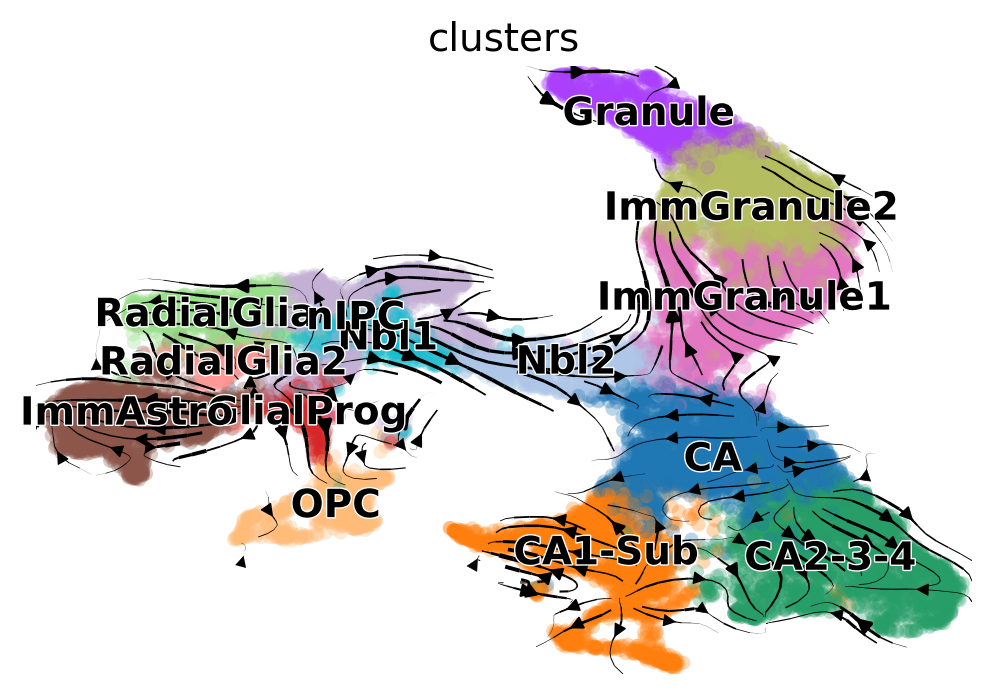

In [10]:
scv.pl.velocity_embedding_stream(adata, basis='umap', vkey='standard_velocity')

This system has neural stem cells (nIPC cluster) which actively cycle to give origin to neuroblasts (Nbl1/Nbl2 clusters), radial glia, glial progenitors and immature astrocytes (ImmAstro cluster). 

Thus, we might be interested in scoring cell cycle gene signatures on these cells. scVelo uses the function `scv.tl.score_genes_cell_cycle` for this task. Next, we can visualize it on top of our UMAP embedding:

calculating cell cycle phase
-->     'S_score' and 'G2M_score', scores of cell cycle phases (adata.obs)


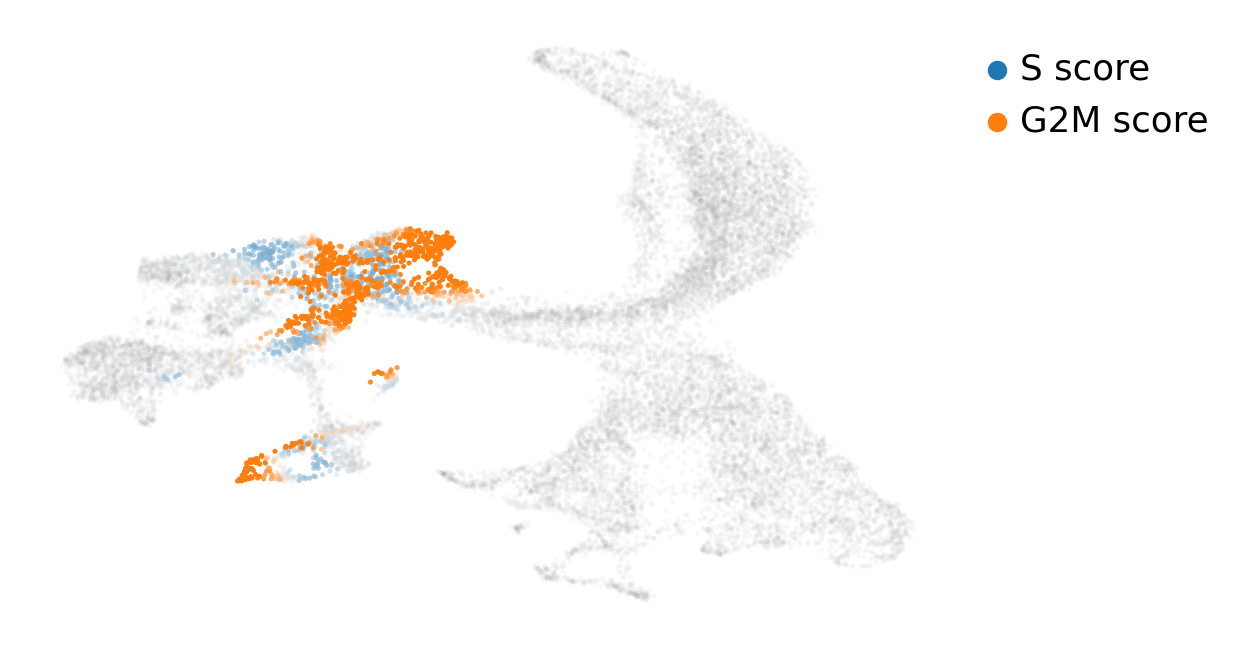

In [11]:
scv.tl.score_genes_cell_cycle(adata)
scv.pl.scatter(adata, basis='umap', color_gradients=['S_score', 'G2M_score'], smooth=True, perc=[5, 95])

One of the uses of RNA velocity is to obtain more accurate estimates of pseudotime (a measure of how well-differentiated a cell is along a cellular trajectory). We can also visualize the pseudotime estimate on our UMAP embedding:

computing terminal states
    identified 7 regions of root cells and 5 regions of end points .
    finished (0:00:03) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


/home/davi/.local/lib/python3.10/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


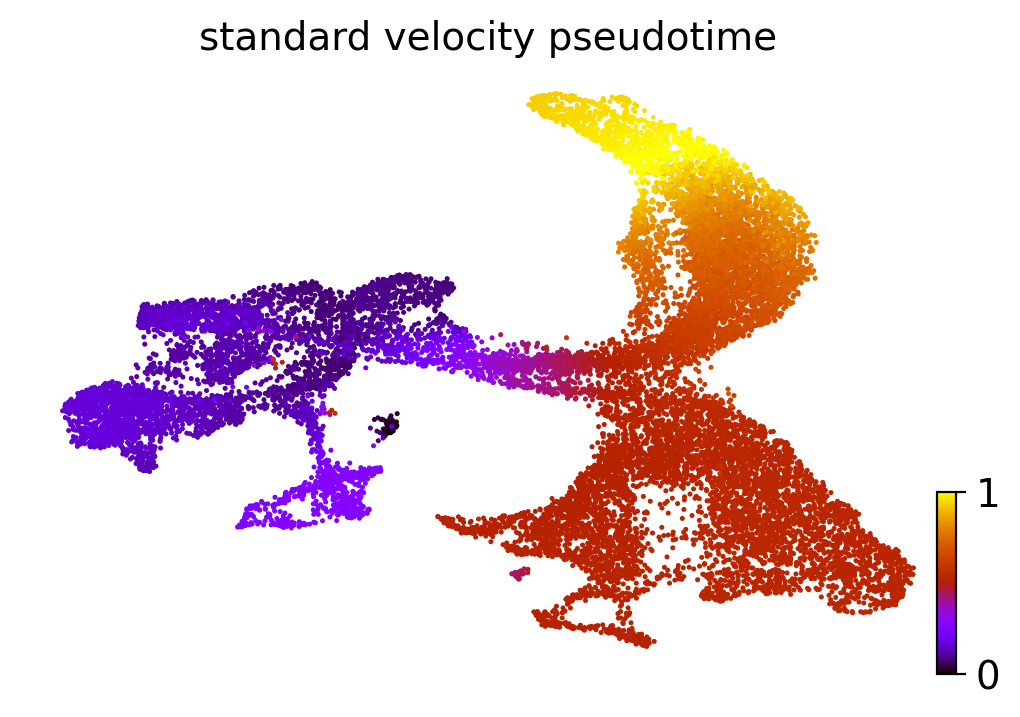

In [12]:
scv.tl.velocity_pseudotime(adata, vkey='standard_velocity')
scv.pl.scatter(adata, basis='umap', color='standard_velocity_pseudotime', cmap='gnuplot')

## Topological workflow

Now that we have executed the current standard workflow, we can follow up with TopOMetry. For that we'll:

1) estimate the intrinsic dimensionalities (i.d.) of our data
2) compute some topological representations with a TopOGraph object
3) give these representations to scvelo for computing the RNA velocity
4) use these representations to visualize RNA velocity and pseudotime

Let's start by estimating the local i.d.:

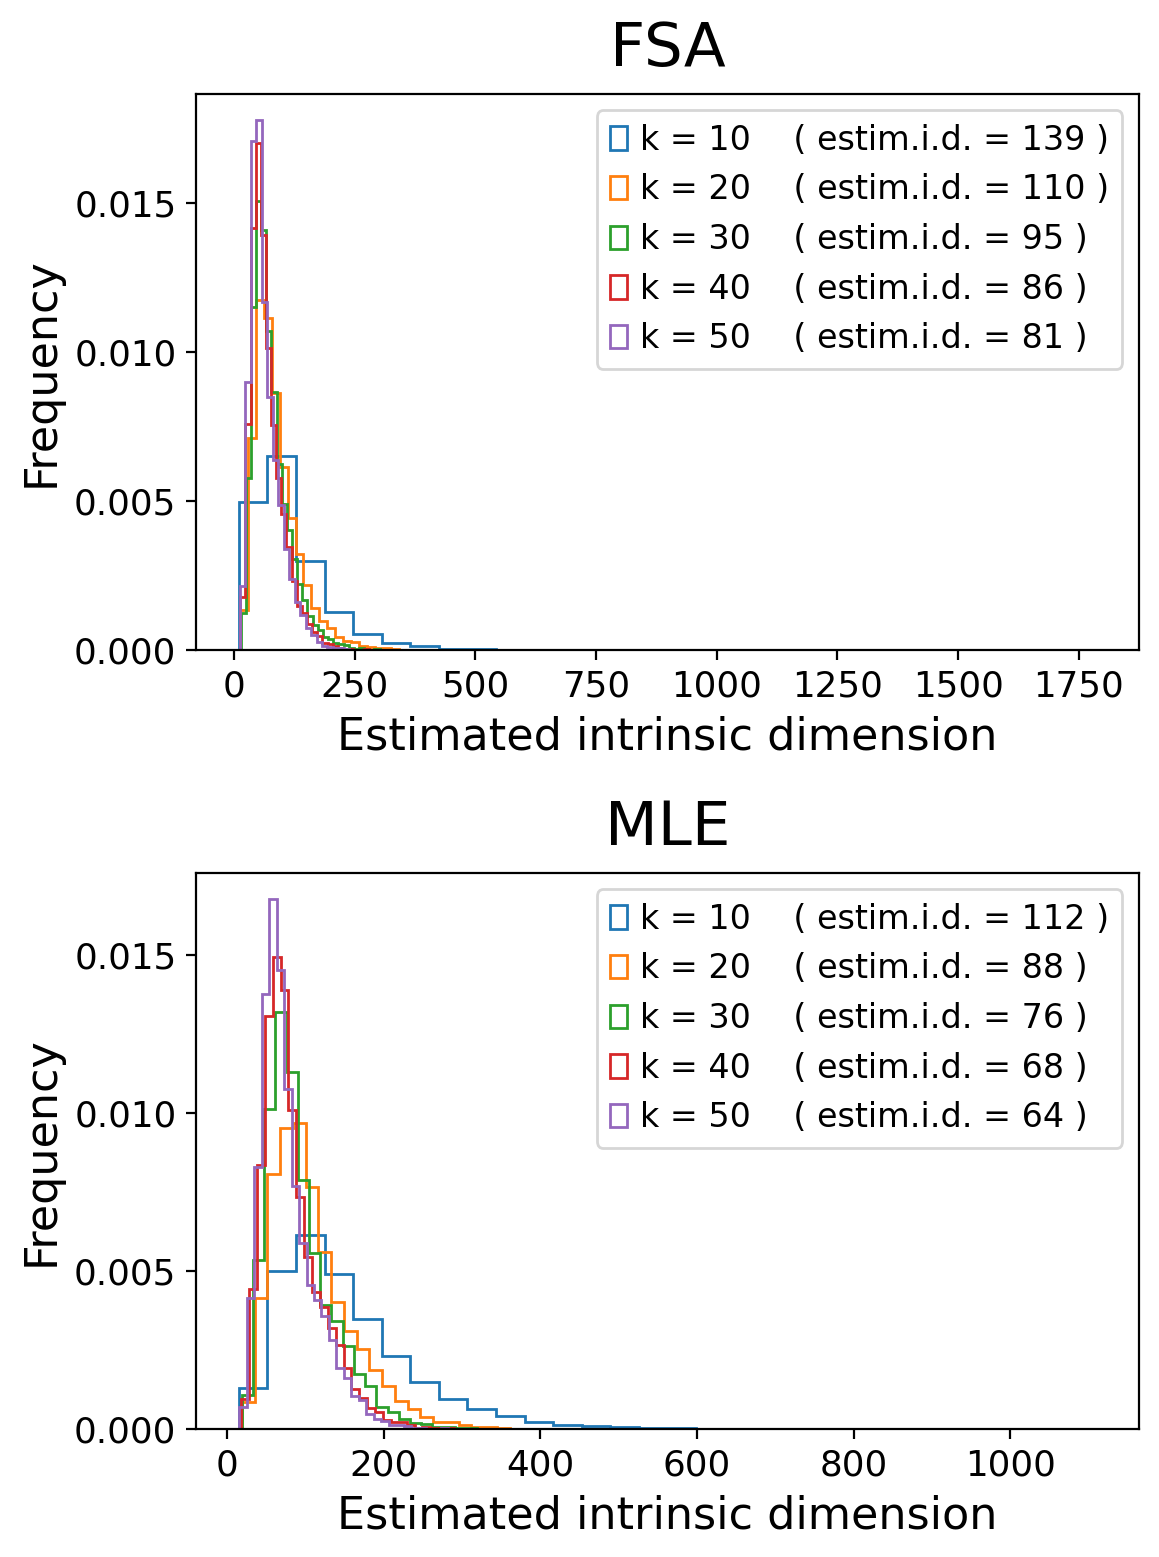

In [14]:
# Estimate intrinsic dimensionalities
tp.tpgraph.IntrinsicDim(
        methods=['fsa','mle'], 
        k=range(10, 60, 10),
        backend='hnswlib',  
        metric='euclidean',
        n_jobs=-1, 
        plot=True, 
        random_state=None).fit(adata.X)

From these results, we see that we should around 200 eigenvectors to faithfully represent this data:

Computing neighborhood graph...
 Base kNN graph computed in 4.788873 (sec)
 Fitted the bw_adaptive kernel in 0.647599 (sec)
Computing eigenbasis...
 Fitted eigenbasis with multiscale Diffusion Maps from the bw_adaptive kernel in 15.022799 (sec)
    Building topological graph from eigenbasis...
        Computing neighborhood graph...
 Computed in 0.158337 (sec)
 Fitted the bw_adaptive graph kernel in 0.643579 (sec)
 Computed MAP in 9.302376 (sec)
 Computed PaCMAP in 22.512149 (sec)


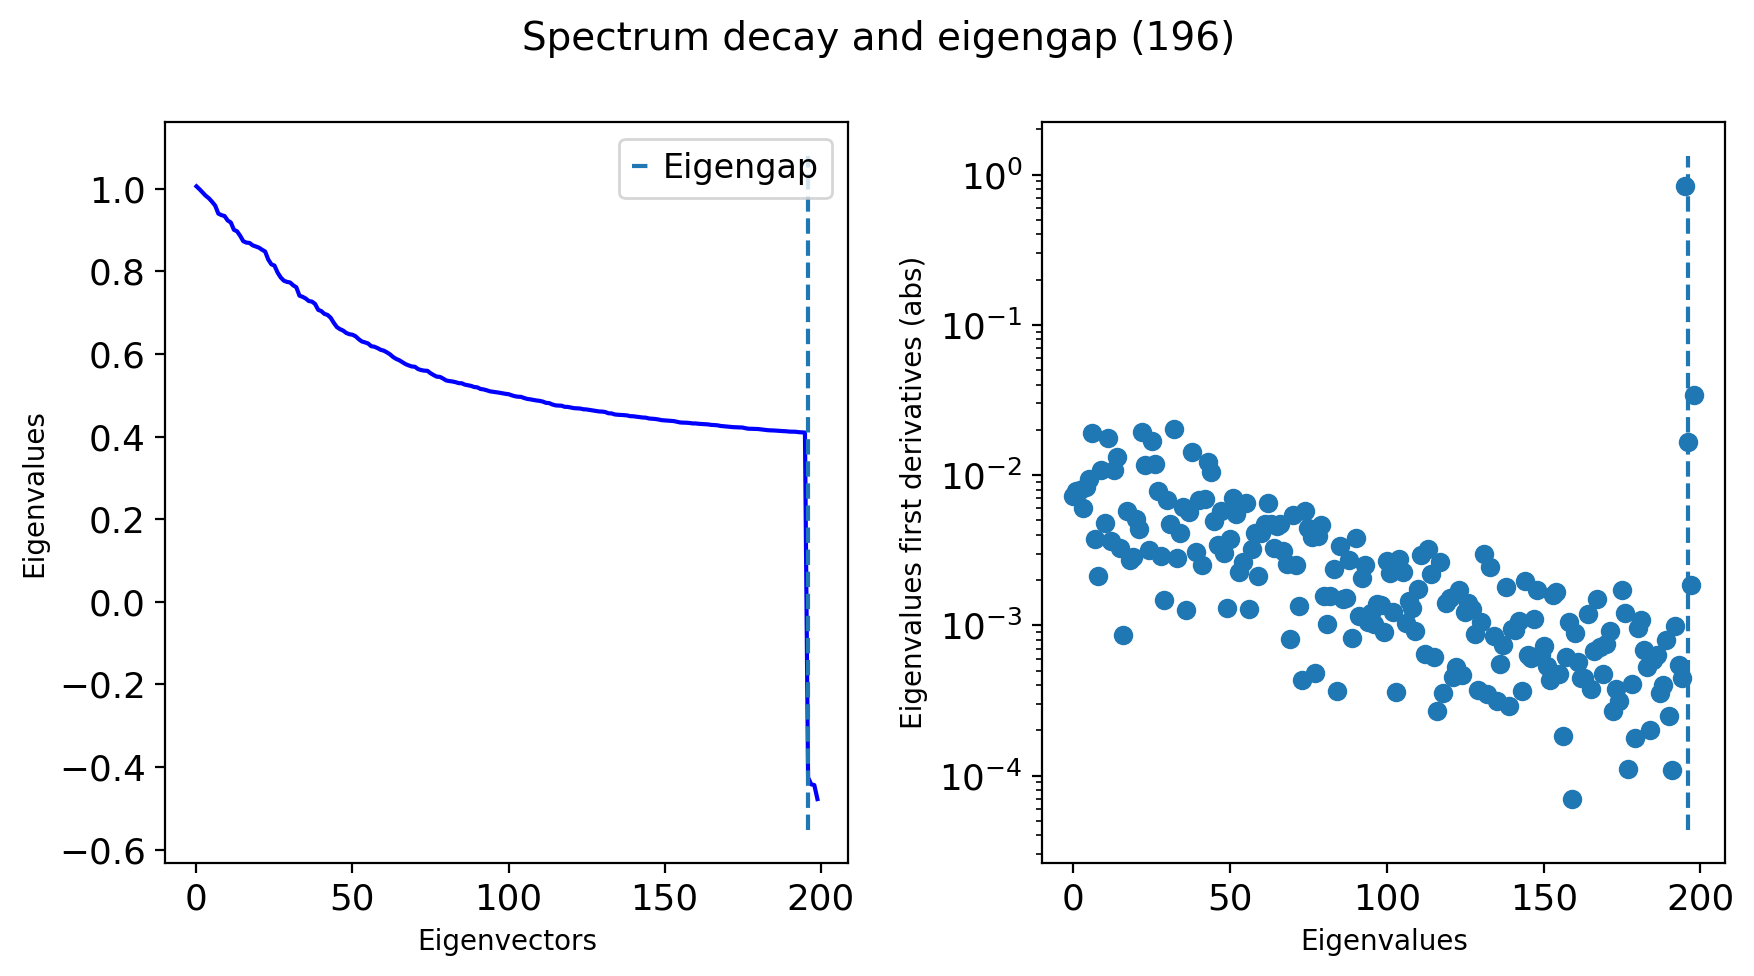

In [19]:
# Run TopOMetry

# Create a TopOGraph object with the desired parameters
tg = tp.TopOGraph(n_eigs=200, n_jobs=-1, verbosity=1, random_state=42)

# Fit some models to the data
adata = tp.sc.topological_workflow(adata, tg,
                                    kernels=['bw_adaptive'],
                                      eigenmap_methods=['msDM'],
                                        projections=['MAP', 'PaCMAP'])

# Plot an eigenspectrum (msDM in this case)
tg.eigenspectrum()

We managed to find an eigengap at around 100 dimensions, so that'll work! 

Let's now rename some of the information that was added to the AnnData object, for convenience:

In [20]:
adata.obsm['X_topoMAP'] = adata.obsm['X_MAP of bw_adaptive from msDM with bw_adaptive']
adata.obs['topo_leiden'] = adata.obs['bw_adaptive from msDM with bw_adaptive_leiden']
adata.obs['original_clusters'] = adata.obs['clusters']

And visualize a topological embedding:

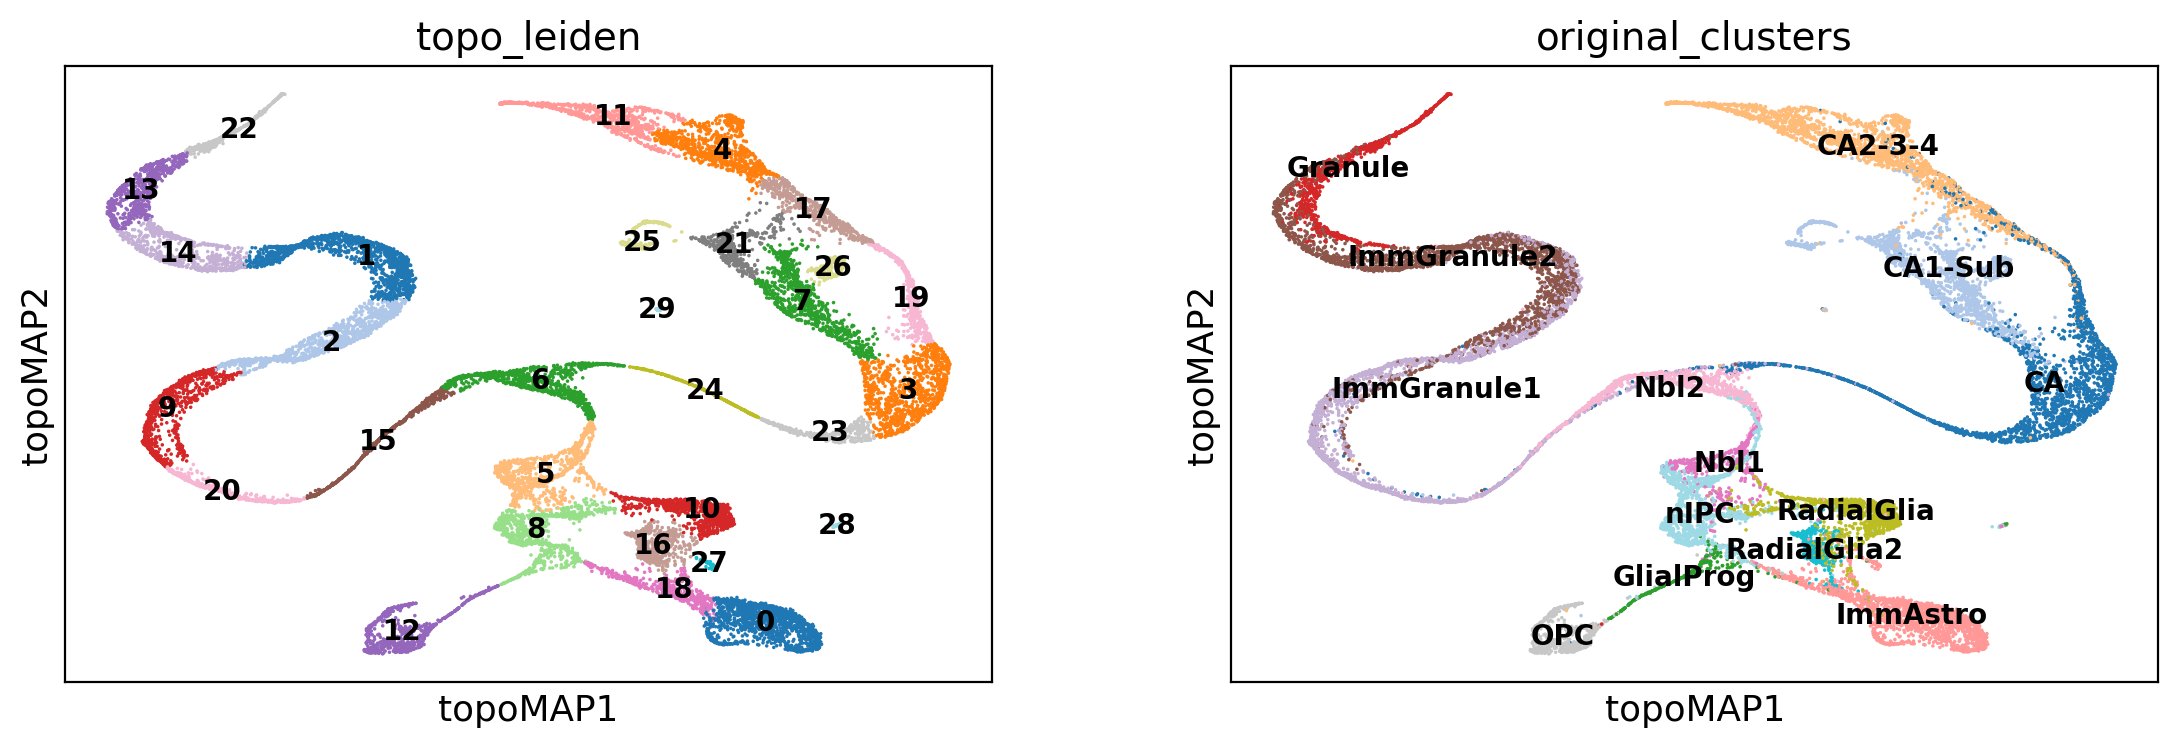

In [21]:
sc.pl.embedding(adata, basis='topoMAP', color=['topo_leiden', 'original_clusters'],
                 palette='tab20', ncols=2, legend_loc='on data', legend_fontsize=10)

Now we can use the learned topological representation to learn the directed k-nearest-neighbors graphs needed in RNA velocity:

In [23]:
scv.pp.moments(adata, use_rep='X_msDM with bw_adaptive', n_neighbors=10)

computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


And use them to estimate a new estimate of the RNA velocity:

In [24]:
scv.tl.velocity(adata, vkey='topometry_velocity')
scv.tl.velocity_graph(adata, vkey='topometry_velocity')

computing velocities
    finished (0:00:04) --> added 
    'topometry_velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/12 cores)


  0%|          | 0/18213 [00:00<?, ?cells/s]

    finished (0:00:29) --> added 
    'topometry_velocity_graph', sparse matrix with cosine correlations (adata.uns)


Next, visualize the results:

computing velocity embedding
    finished (0:00:03) --> added
    'topometry_velocity_topoMAP', embedded velocity vectors (adata.obsm)


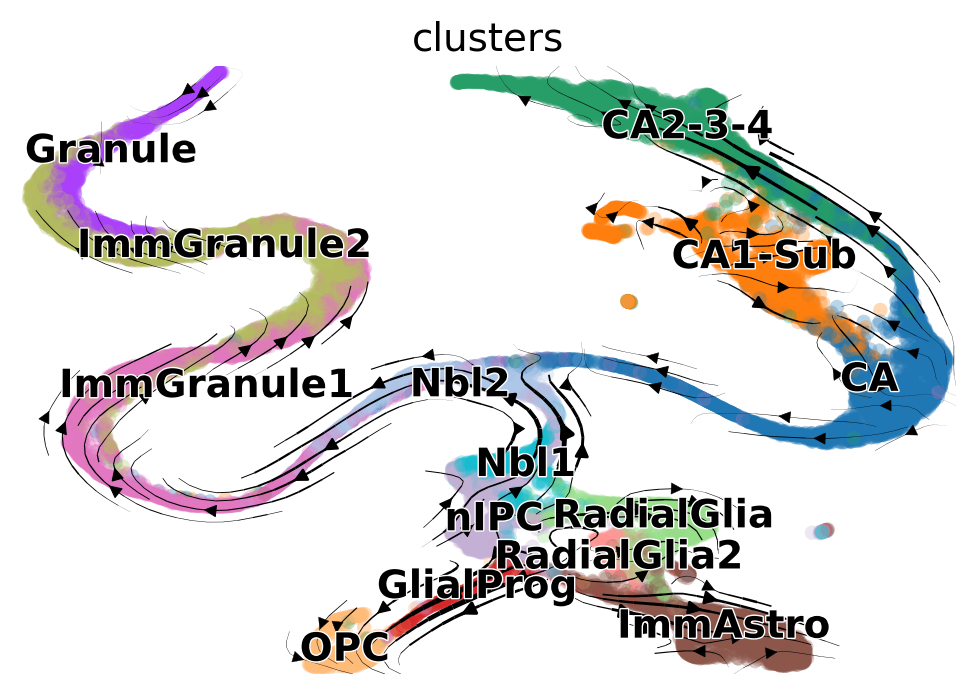

In [25]:
scv.pl.velocity_embedding_stream(adata, basis='topoMAP', vkey='topometry_velocity')

What about cell cycle genes?

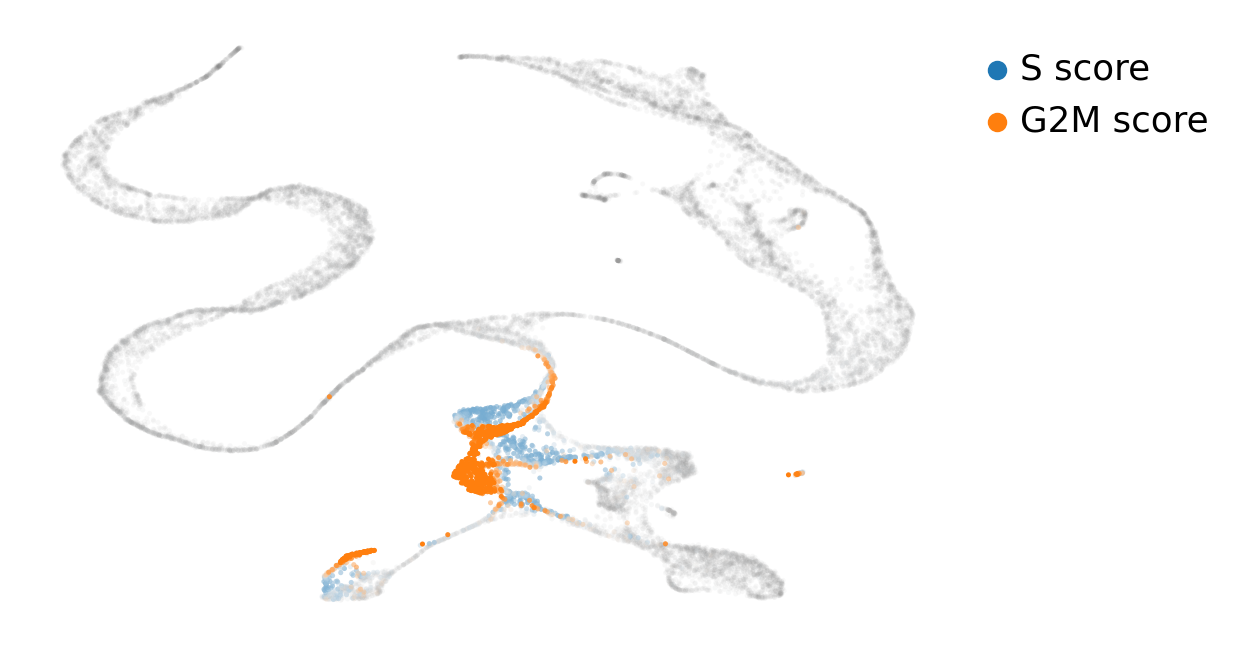

In [26]:
scv.pl.scatter(adata, basis='topoMAP', color_gradients=['S_score', 'G2M_score'], smooth=True, perc=[5, 95])

As we can see, cycling cells are far better represented with the TopOMetry model than with the standard UMAP visualization obtained with Scanpy: they are in a reasonably circular shape and cells ongoing different phases are not scattered all around.

What about the RNA velocity pseudotime?

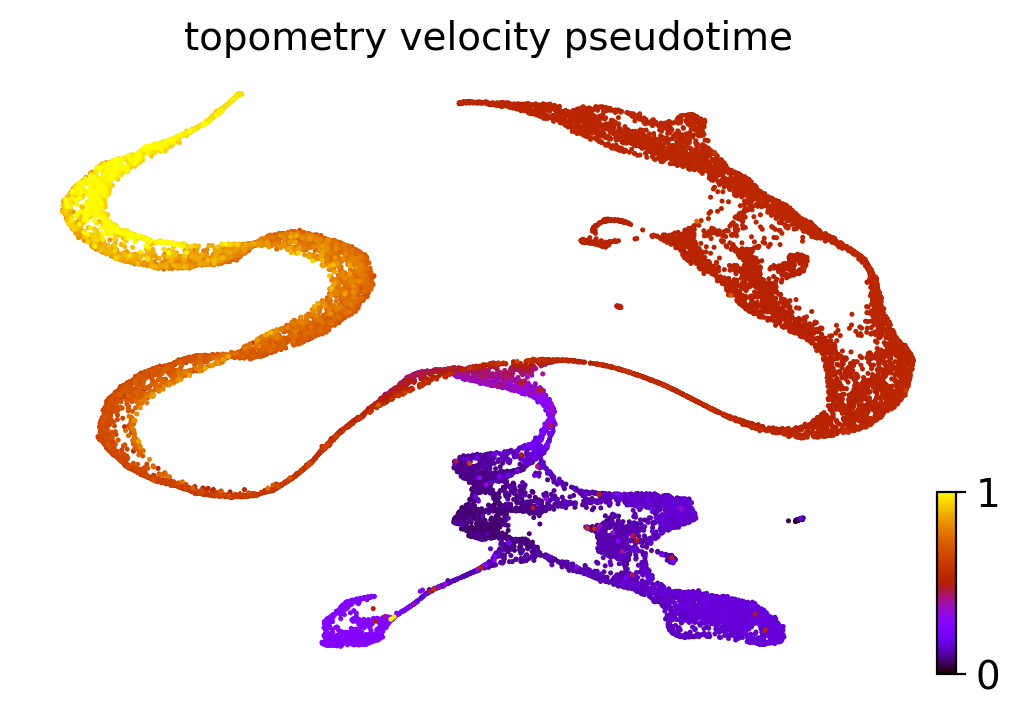

In [27]:
scv.tl.velocity_pseudotime(adata, vkey='topometry_velocity')
scv.pl.scatter(adata, basis='topoMAP', color='topometry_velocity_pseudotime', cmap='gnuplot')

So we also obtained good estimates of the pseudotime! The extremities with higher values correspond to mature neurons, while the cycling neural stem cells present the lowest values.

One of the reasons why TopOMetry excels at representing such lineages is its use of Diffusion Components. We can also visualize how each individual component encodes a specific region of the manifold:

In [28]:
for i in range(np.shape(adata.obsm['X_msDM with bw_adaptive'])[1]):
    adata.obs['DC_' + str(i)] = adata.obsm['X_msDM with bw_adaptive'][:,i]

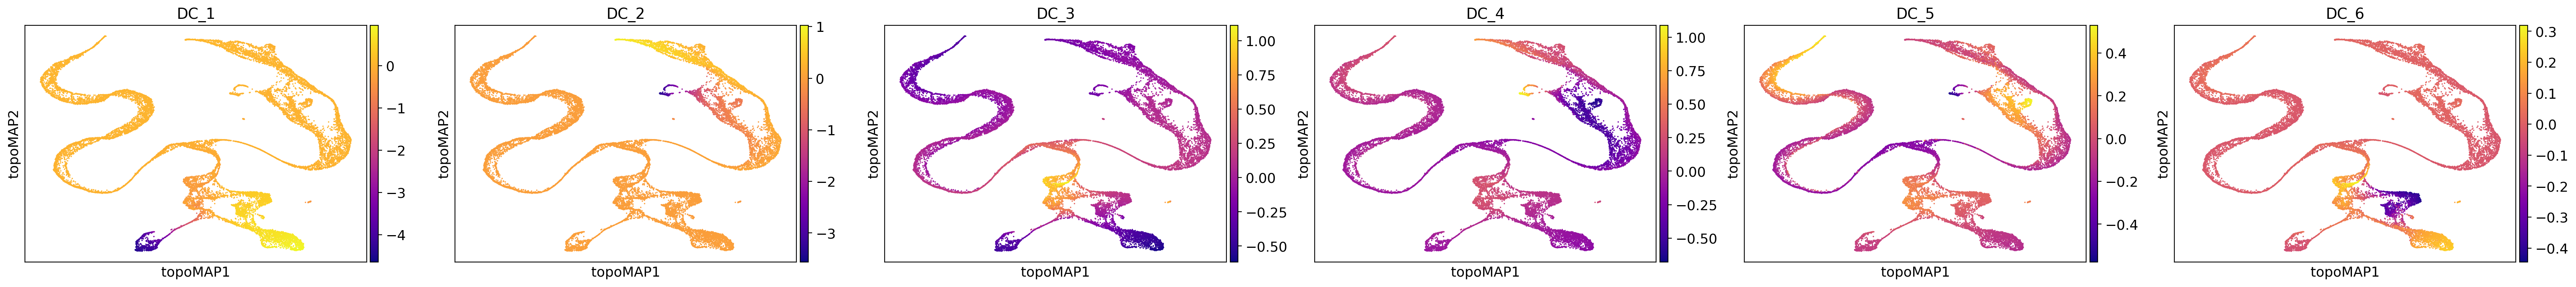

In [29]:
sc.pl.embedding(adata, basis='topoMAP', color=['DC_1', 'DC_2', 'DC_3', 'DC_4', 'DC_5', 'DC_6'], cmap='plasma', ncols=6, legend_fontsize=22)

As we can see, each component is associated with a particular region of the manifold. Note that the directionality is meaningless, meaning we can invert it without changing its effects. This can be particularly useful when looking for genes that correlate with these components to search for the drivers of the differentiation lineages.

Finally, we can save our AnnData object:

In [30]:
adata.write_h5ad('LaMannoBrain_post_topo.h5ad')

And our TopOGraph:

In [31]:
tg.write_pkl('LaMannoBrain_post_topo.pkl')

TopOGraph saved at LaMannoBrain_post_topo.pkl


That's it for this tutorial! I hope this can be useful for your research.